## Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import os

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Transform the Data

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

## Load the Data

In [ ]:
# Load CIFAR 10 dataset with training and testing Components
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Visualize a few images

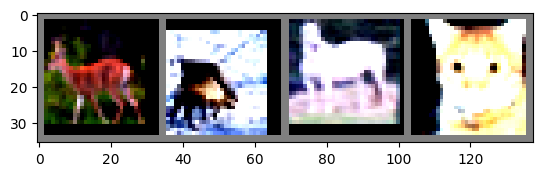

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


batch_size = 4

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))

## Define ResNet Architecture

We have modified the architecture to reduce blocks in layers. The following modifications were made to ResNet 18 architecture found at https://github.com/kuangliu/pytorch-cifar. 

- Reducing blocks from 2 to 1 in layer 2,3,4 
- Dropout of 0.4 added 
- SGD Optimizer 

In [ ]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.dropout = nn.Dropout(0.4)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,1,1,1])

In [ ]:
net = ResNet18()

In [ ]:
## Move model to CUDA
net = net.to(device)

## Model Summary and Parameters
eters
We are checking total number of trainable params and visualizing the model summary

In [ ]:
summary(net, input_size = (3,32,32), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
total_trainable_parameters = sum(p.numel() for p in net.parameters() if p.requires_grad)

In [ ]:
print("Total Trainable Parameters: %d"%total_trainable_parameters)

Total Trainable Parameters: 4977226


Which is under 5 million :)

## Define Train and Test functions 

In [ ]:
# Training
def train(epoch):
    
    ## Setting the model in training mode
    net.train()
    
    ## Initialize Epoch loss and accuracy 
    train_loss = 0
    train_acc = 0 
    
    ## Number of correct examples
    correct = 0
    total = 0


    for batch_idx, (inputs, targets) in enumerate(trainloader):
        ## Movie inputs and targets to cuda
        inputs, targets = inputs.to(device), targets.to(device)

        ## Set gradients to zero after every batch
        optimizer.zero_grad()

        ## Get predictions
        outputs = net(inputs)

        ## Compute Loss
        loss = criterion(outputs, targets)

        ## Do backprop
        loss.backward()

        ## Update weights 
        optimizer.step()

        ## Add loss
        train_loss += loss.item()
        
        ## Computer Number of correct examples
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    
    
    
    train_acc += 100.*correct/total


   
    
    return train_loss / len(trainloader) , train_acc

In [ ]:
def test(epoch):
    ## Setting models to evaluation mode
    net.eval()
    
    ## Initialize epoch loss and accuracy
    test_loss = 0
    test_acc = 0 

    ## Number of correct examples
    correct = 0
    total = 0


    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            ## Move inputs and targets to cuda

            inputs, targets = inputs.to(device), targets.to(device)

            ## Get predictions

            outputs = net(inputs)

            ## Compute Loss
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            ## Computer Accuracy 
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    test_acc = 100.*correct/total
    
    return test_loss / len(testloader) , test_acc

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Defining Loss function, optimizer and LR Scheduler

In [ ]:
LEARNING_RATE = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = LEARNING_RATE,
                       weight_decay=5e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

criterion = criterion.to(device)

## Train the model


In [ ]:
EPOCHS = 150
best_testing_accuracy = 0 

## Define model history to store accuracy and losses

history = {}
history["accuracy"] = []
history["test_accuracy"] = []
history["loss"] = []
history["test_loss"] = []

In [ ]:
## First train for 100 

for epoch in tqdm(range(EPOCHS)):
  
  start_time = time.time()

  train_loss, train_acc = train(epoch)
  test_loss, test_acc = test(epoch)

  scheduler.step()

  history["accuracy"].append(train_acc)
  history["test_accuracy"].append(test_acc)
  history["loss"].append(train_loss)
  history["test_loss"].append(test_loss)


  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if test_acc > best_testing_accuracy:
    best_testing_accuracy = test_acc
    torch.save(net.state_dict(), 'model.pt')

  
  print('Training Loss: %.3f | Training Acc: %.3f%% | Testing Loss: %.3f | Testing Acc:%.3f%%'
                  % (train_loss, train_acc, test_loss, test_acc))

  1%|          | 1/150 [00:36<1:31:34, 36.87s/it]

Training Loss: 1.686 | Training Acc: 38.124% | Testing Loss: 1.399 | Testing Acc:49.160%


  1%|▏         | 2/150 [01:13<1:30:25, 36.66s/it]

Training Loss: 1.178 | Training Acc: 57.310% | Testing Loss: 1.235 | Testing Acc:58.040%


  2%|▏         | 3/150 [01:50<1:30:51, 37.09s/it]

Training Loss: 0.923 | Training Acc: 67.608% | Testing Loss: 1.064 | Testing Acc:65.700%


  3%|▎         | 4/150 [02:27<1:29:29, 36.78s/it]

Training Loss: 0.770 | Training Acc: 73.066% | Testing Loss: 1.080 | Testing Acc:66.580%


  3%|▎         | 5/150 [03:04<1:28:50, 36.76s/it]

Training Loss: 0.663 | Training Acc: 77.068% | Testing Loss: 0.872 | Testing Acc:71.740%


  4%|▍         | 6/150 [03:40<1:28:14, 36.77s/it]

Training Loss: 0.598 | Training Acc: 79.344% | Testing Loss: 0.621 | Testing Acc:78.470%


  5%|▍         | 7/150 [04:17<1:27:14, 36.60s/it]

Training Loss: 0.555 | Training Acc: 81.030% | Testing Loss: 0.639 | Testing Acc:78.140%


  5%|▌         | 8/150 [04:53<1:26:43, 36.65s/it]

Training Loss: 0.530 | Training Acc: 81.754% | Testing Loss: 0.712 | Testing Acc:76.720%


  6%|▌         | 9/150 [05:30<1:26:07, 36.65s/it]

Training Loss: 0.504 | Training Acc: 82.908% | Testing Loss: 0.681 | Testing Acc:76.170%


  7%|▋         | 10/150 [06:07<1:26:02, 36.88s/it]

Training Loss: 0.484 | Training Acc: 83.554% | Testing Loss: 0.795 | Testing Acc:75.390%


  7%|▋         | 11/150 [06:43<1:24:41, 36.56s/it]

Training Loss: 0.469 | Training Acc: 84.026% | Testing Loss: 0.571 | Testing Acc:80.190%


  8%|▊         | 12/150 [07:20<1:24:15, 36.63s/it]

Training Loss: 0.462 | Training Acc: 84.270% | Testing Loss: 0.623 | Testing Acc:78.520%


  9%|▊         | 13/150 [07:56<1:23:21, 36.51s/it]

Training Loss: 0.440 | Training Acc: 85.144% | Testing Loss: 0.625 | Testing Acc:80.070%


  9%|▉         | 14/150 [08:34<1:23:22, 36.79s/it]

Training Loss: 0.434 | Training Acc: 85.182% | Testing Loss: 0.609 | Testing Acc:80.550%


 10%|█         | 15/150 [09:11<1:23:13, 36.99s/it]

Training Loss: 0.426 | Training Acc: 85.434% | Testing Loss: 0.697 | Testing Acc:78.810%


 11%|█         | 16/150 [09:47<1:22:05, 36.76s/it]

Training Loss: 0.418 | Training Acc: 85.742% | Testing Loss: 0.723 | Testing Acc:76.890%


 11%|█▏        | 17/150 [10:24<1:21:38, 36.83s/it]

Training Loss: 0.414 | Training Acc: 85.904% | Testing Loss: 0.630 | Testing Acc:80.250%


 12%|█▏        | 18/150 [11:01<1:20:43, 36.69s/it]

Training Loss: 0.407 | Training Acc: 85.988% | Testing Loss: 0.547 | Testing Acc:82.320%


 13%|█▎        | 19/150 [11:38<1:20:12, 36.74s/it]

Training Loss: 0.403 | Training Acc: 86.266% | Testing Loss: 0.842 | Testing Acc:74.110%


 13%|█▎        | 20/150 [12:13<1:19:00, 36.47s/it]

Training Loss: 0.392 | Training Acc: 86.688% | Testing Loss: 0.649 | Testing Acc:79.280%


 14%|█▍        | 21/150 [12:50<1:18:25, 36.47s/it]

Training Loss: 0.393 | Training Acc: 86.718% | Testing Loss: 0.573 | Testing Acc:81.680%


 15%|█▍        | 22/150 [13:26<1:17:30, 36.33s/it]

Training Loss: 0.386 | Training Acc: 86.890% | Testing Loss: 0.699 | Testing Acc:78.780%


 15%|█▌        | 23/150 [14:03<1:17:08, 36.44s/it]

Training Loss: 0.386 | Training Acc: 86.938% | Testing Loss: 0.607 | Testing Acc:80.410%


 16%|█▌        | 24/150 [14:39<1:16:42, 36.53s/it]

Training Loss: 0.387 | Training Acc: 86.696% | Testing Loss: 0.574 | Testing Acc:81.400%


 17%|█▋        | 25/150 [15:16<1:16:08, 36.55s/it]

Training Loss: 0.377 | Training Acc: 87.252% | Testing Loss: 0.512 | Testing Acc:83.350%


 17%|█▋        | 26/150 [15:52<1:15:08, 36.36s/it]

Training Loss: 0.375 | Training Acc: 87.080% | Testing Loss: 0.508 | Testing Acc:83.130%


 18%|█▊        | 27/150 [16:28<1:14:44, 36.46s/it]

Training Loss: 0.370 | Training Acc: 87.332% | Testing Loss: 0.568 | Testing Acc:81.970%


 19%|█▊        | 28/150 [17:06<1:14:36, 36.69s/it]

Training Loss: 0.365 | Training Acc: 87.540% | Testing Loss: 0.672 | Testing Acc:79.090%


 19%|█▉        | 29/150 [17:42<1:13:42, 36.55s/it]

Training Loss: 0.364 | Training Acc: 87.660% | Testing Loss: 0.574 | Testing Acc:80.750%


 20%|██        | 30/150 [18:19<1:13:21, 36.68s/it]

Training Loss: 0.362 | Training Acc: 87.710% | Testing Loss: 0.667 | Testing Acc:79.230%


 21%|██        | 31/150 [18:55<1:12:13, 36.42s/it]

Training Loss: 0.366 | Training Acc: 87.524% | Testing Loss: 0.464 | Testing Acc:84.730%


 21%|██▏       | 32/150 [19:31<1:11:39, 36.43s/it]

Training Loss: 0.359 | Training Acc: 87.824% | Testing Loss: 0.592 | Testing Acc:81.390%


 22%|██▏       | 33/150 [20:07<1:10:43, 36.27s/it]

Training Loss: 0.357 | Training Acc: 87.740% | Testing Loss: 0.545 | Testing Acc:83.060%


 23%|██▎       | 34/150 [20:44<1:10:23, 36.41s/it]

Training Loss: 0.353 | Training Acc: 87.934% | Testing Loss: 0.526 | Testing Acc:83.090%


 23%|██▎       | 35/150 [21:20<1:09:54, 36.47s/it]

Training Loss: 0.357 | Training Acc: 87.774% | Testing Loss: 0.590 | Testing Acc:81.360%


 24%|██▍       | 36/150 [21:57<1:09:04, 36.36s/it]

Training Loss: 0.354 | Training Acc: 88.066% | Testing Loss: 0.611 | Testing Acc:80.750%


 25%|██▍       | 37/150 [22:33<1:08:15, 36.25s/it]

Training Loss: 0.346 | Training Acc: 88.268% | Testing Loss: 0.534 | Testing Acc:82.720%


 25%|██▌       | 38/150 [23:09<1:07:44, 36.29s/it]

Training Loss: 0.343 | Training Acc: 88.364% | Testing Loss: 0.510 | Testing Acc:83.480%


 26%|██▌       | 39/150 [23:45<1:06:57, 36.19s/it]

Training Loss: 0.345 | Training Acc: 88.346% | Testing Loss: 0.616 | Testing Acc:80.160%


 27%|██▋       | 40/150 [24:22<1:06:56, 36.52s/it]

Training Loss: 0.341 | Training Acc: 88.532% | Testing Loss: 0.524 | Testing Acc:83.170%


 27%|██▋       | 41/150 [24:58<1:05:58, 36.31s/it]

Training Loss: 0.340 | Training Acc: 88.618% | Testing Loss: 0.462 | Testing Acc:84.690%


 28%|██▊       | 42/150 [25:34<1:05:18, 36.29s/it]

Training Loss: 0.342 | Training Acc: 88.250% | Testing Loss: 0.584 | Testing Acc:81.880%


 29%|██▊       | 43/150 [26:10<1:04:27, 36.14s/it]

Training Loss: 0.337 | Training Acc: 88.586% | Testing Loss: 0.566 | Testing Acc:81.480%


 29%|██▉       | 44/150 [26:46<1:03:58, 36.21s/it]

Training Loss: 0.338 | Training Acc: 88.430% | Testing Loss: 0.508 | Testing Acc:84.090%


 30%|███       | 45/150 [27:23<1:03:48, 36.46s/it]

Training Loss: 0.332 | Training Acc: 88.852% | Testing Loss: 0.614 | Testing Acc:81.250%


 31%|███       | 46/150 [28:00<1:03:06, 36.40s/it]

Training Loss: 0.328 | Training Acc: 88.870% | Testing Loss: 0.451 | Testing Acc:85.000%


 31%|███▏      | 47/150 [28:37<1:02:48, 36.59s/it]

Training Loss: 0.325 | Training Acc: 88.852% | Testing Loss: 0.608 | Testing Acc:82.220%


 32%|███▏      | 48/150 [29:13<1:01:50, 36.37s/it]

Training Loss: 0.335 | Training Acc: 88.510% | Testing Loss: 0.583 | Testing Acc:81.860%


 33%|███▎      | 49/150 [29:49<1:01:29, 36.53s/it]

Training Loss: 0.328 | Training Acc: 88.920% | Testing Loss: 0.425 | Testing Acc:85.750%


 33%|███▎      | 50/150 [30:26<1:00:47, 36.48s/it]

Training Loss: 0.330 | Training Acc: 88.710% | Testing Loss: 0.586 | Testing Acc:81.450%


 34%|███▍      | 51/150 [31:03<1:00:29, 36.66s/it]

Training Loss: 0.326 | Training Acc: 88.970% | Testing Loss: 0.622 | Testing Acc:80.320%


 35%|███▍      | 52/150 [31:39<59:23, 36.36s/it]  

Training Loss: 0.320 | Training Acc: 89.242% | Testing Loss: 0.529 | Testing Acc:82.840%


 35%|███▌      | 53/150 [32:15<58:46, 36.36s/it]

Training Loss: 0.318 | Training Acc: 89.158% | Testing Loss: 0.433 | Testing Acc:85.940%


 36%|███▌      | 54/150 [32:51<57:59, 36.25s/it]

Training Loss: 0.321 | Training Acc: 89.102% | Testing Loss: 0.498 | Testing Acc:83.770%


 37%|███▋      | 55/150 [33:27<57:26, 36.28s/it]

Training Loss: 0.314 | Training Acc: 89.216% | Testing Loss: 0.440 | Testing Acc:85.630%


 37%|███▋      | 56/150 [34:04<57:02, 36.41s/it]

Training Loss: 0.308 | Training Acc: 89.484% | Testing Loss: 0.451 | Testing Acc:85.220%


 38%|███▊      | 57/150 [34:40<56:22, 36.37s/it]

Training Loss: 0.312 | Training Acc: 89.272% | Testing Loss: 0.573 | Testing Acc:81.800%


 39%|███▊      | 58/150 [35:16<55:31, 36.21s/it]

Training Loss: 0.311 | Training Acc: 89.268% | Testing Loss: 0.430 | Testing Acc:85.770%


 39%|███▉      | 59/150 [35:52<54:56, 36.23s/it]

Training Loss: 0.313 | Training Acc: 89.356% | Testing Loss: 0.629 | Testing Acc:81.190%


 40%|████      | 60/150 [36:30<54:50, 36.56s/it]

Training Loss: 0.304 | Training Acc: 89.642% | Testing Loss: 0.452 | Testing Acc:85.720%


 41%|████      | 61/150 [37:09<55:32, 37.44s/it]

Training Loss: 0.306 | Training Acc: 89.512% | Testing Loss: 0.450 | Testing Acc:85.310%


 41%|████▏     | 62/150 [37:45<54:19, 37.04s/it]

Training Loss: 0.302 | Training Acc: 89.678% | Testing Loss: 0.409 | Testing Acc:86.940%


 42%|████▏     | 63/150 [38:23<53:52, 37.16s/it]

Training Loss: 0.300 | Training Acc: 89.852% | Testing Loss: 0.532 | Testing Acc:83.470%


 43%|████▎     | 64/150 [38:59<52:55, 36.93s/it]

Training Loss: 0.299 | Training Acc: 89.656% | Testing Loss: 0.541 | Testing Acc:82.340%


 43%|████▎     | 65/150 [39:35<51:56, 36.66s/it]

Training Loss: 0.297 | Training Acc: 89.920% | Testing Loss: 0.441 | Testing Acc:85.780%


 44%|████▍     | 66/150 [40:11<51:01, 36.45s/it]

Training Loss: 0.292 | Training Acc: 90.084% | Testing Loss: 0.402 | Testing Acc:86.460%


 45%|████▍     | 67/150 [40:48<50:25, 36.45s/it]

Training Loss: 0.294 | Training Acc: 90.084% | Testing Loss: 0.422 | Testing Acc:86.240%


 45%|████▌     | 68/150 [41:24<49:42, 36.37s/it]

Training Loss: 0.286 | Training Acc: 90.340% | Testing Loss: 0.567 | Testing Acc:82.160%


 46%|████▌     | 69/150 [42:01<49:20, 36.55s/it]

Training Loss: 0.288 | Training Acc: 90.208% | Testing Loss: 0.447 | Testing Acc:85.050%


 47%|████▋     | 70/150 [42:36<48:23, 36.30s/it]

Training Loss: 0.292 | Training Acc: 89.960% | Testing Loss: 0.471 | Testing Acc:85.610%


 47%|████▋     | 71/150 [43:13<47:53, 36.37s/it]

Training Loss: 0.286 | Training Acc: 90.234% | Testing Loss: 0.530 | Testing Acc:82.970%


 48%|████▊     | 72/150 [43:50<47:20, 36.41s/it]

Training Loss: 0.287 | Training Acc: 90.208% | Testing Loss: 0.405 | Testing Acc:86.730%


 49%|████▊     | 73/150 [44:26<46:37, 36.33s/it]

Training Loss: 0.281 | Training Acc: 90.358% | Testing Loss: 0.589 | Testing Acc:81.420%


 49%|████▉     | 74/150 [45:03<46:32, 36.74s/it]

Training Loss: 0.281 | Training Acc: 90.380% | Testing Loss: 0.650 | Testing Acc:80.770%


 50%|█████     | 75/150 [45:39<45:34, 36.46s/it]

Training Loss: 0.275 | Training Acc: 90.766% | Testing Loss: 0.467 | Testing Acc:85.150%


 51%|█████     | 76/150 [46:15<44:49, 36.35s/it]

Training Loss: 0.272 | Training Acc: 90.732% | Testing Loss: 0.573 | Testing Acc:80.970%


 51%|█████▏    | 77/150 [46:51<43:57, 36.14s/it]

Training Loss: 0.273 | Training Acc: 90.702% | Testing Loss: 0.552 | Testing Acc:83.670%


 52%|█████▏    | 78/150 [47:27<43:30, 36.25s/it]

Training Loss: 0.270 | Training Acc: 90.832% | Testing Loss: 0.522 | Testing Acc:83.290%


 53%|█████▎    | 79/150 [48:04<43:03, 36.39s/it]

Training Loss: 0.266 | Training Acc: 91.062% | Testing Loss: 0.543 | Testing Acc:82.260%


 53%|█████▎    | 80/150 [48:41<42:28, 36.41s/it]

Training Loss: 0.272 | Training Acc: 90.808% | Testing Loss: 0.465 | Testing Acc:84.920%


 54%|█████▍    | 81/150 [49:17<41:45, 36.31s/it]

Training Loss: 0.262 | Training Acc: 91.132% | Testing Loss: 0.531 | Testing Acc:83.970%


 55%|█████▍    | 82/150 [49:53<41:18, 36.46s/it]

Training Loss: 0.259 | Training Acc: 91.176% | Testing Loss: 0.725 | Testing Acc:79.050%


 55%|█████▌    | 83/150 [50:29<40:29, 36.26s/it]

Training Loss: 0.264 | Training Acc: 91.086% | Testing Loss: 0.475 | Testing Acc:85.390%


 56%|█████▌    | 84/150 [51:06<40:06, 36.46s/it]

Training Loss: 0.257 | Training Acc: 91.328% | Testing Loss: 0.438 | Testing Acc:86.480%


 57%|█████▋    | 85/150 [51:43<39:37, 36.57s/it]

Training Loss: 0.258 | Training Acc: 91.278% | Testing Loss: 0.541 | Testing Acc:83.920%


 57%|█████▋    | 86/150 [52:19<38:55, 36.49s/it]

Training Loss: 0.248 | Training Acc: 91.606% | Testing Loss: 0.385 | Testing Acc:87.370%


 58%|█████▊    | 87/150 [52:55<38:07, 36.32s/it]

Training Loss: 0.252 | Training Acc: 91.332% | Testing Loss: 0.487 | Testing Acc:85.300%


 59%|█████▊    | 88/150 [53:32<37:33, 36.35s/it]

Training Loss: 0.250 | Training Acc: 91.534% | Testing Loss: 0.447 | Testing Acc:85.740%


 59%|█████▉    | 89/150 [54:08<36:56, 36.33s/it]

Training Loss: 0.246 | Training Acc: 91.644% | Testing Loss: 0.398 | Testing Acc:86.830%


 60%|██████    | 90/150 [54:45<36:26, 36.45s/it]

Training Loss: 0.243 | Training Acc: 91.846% | Testing Loss: 0.456 | Testing Acc:85.370%


 61%|██████    | 91/150 [55:20<35:39, 36.26s/it]

Training Loss: 0.239 | Training Acc: 91.962% | Testing Loss: 0.427 | Testing Acc:85.760%


 61%|██████▏   | 92/150 [55:57<35:04, 36.29s/it]

Training Loss: 0.236 | Training Acc: 91.892% | Testing Loss: 0.695 | Testing Acc:81.010%


 62%|██████▏   | 93/150 [56:33<34:18, 36.12s/it]

Training Loss: 0.238 | Training Acc: 91.940% | Testing Loss: 0.427 | Testing Acc:86.810%


 63%|██████▎   | 94/150 [57:08<33:38, 36.04s/it]

Training Loss: 0.232 | Training Acc: 91.960% | Testing Loss: 0.461 | Testing Acc:85.380%


 63%|██████▎   | 95/150 [57:44<32:55, 35.93s/it]

Training Loss: 0.226 | Training Acc: 92.246% | Testing Loss: 0.363 | Testing Acc:88.240%


 64%|██████▍   | 96/150 [58:21<32:31, 36.14s/it]

Training Loss: 0.229 | Training Acc: 92.100% | Testing Loss: 0.334 | Testing Acc:89.080%


 65%|██████▍   | 97/150 [58:57<31:53, 36.10s/it]

Training Loss: 0.229 | Training Acc: 92.210% | Testing Loss: 0.383 | Testing Acc:87.970%


 65%|██████▌   | 98/150 [59:33<31:23, 36.22s/it]

Training Loss: 0.224 | Training Acc: 92.466% | Testing Loss: 0.427 | Testing Acc:86.590%


 66%|██████▌   | 99/150 [1:00:09<30:42, 36.12s/it]

Training Loss: 0.218 | Training Acc: 92.468% | Testing Loss: 0.410 | Testing Acc:87.140%


 67%|██████▋   | 100/150 [1:00:45<30:07, 36.16s/it]

Training Loss: 0.215 | Training Acc: 92.716% | Testing Loss: 0.448 | Testing Acc:86.540%


 67%|██████▋   | 101/150 [1:01:21<29:26, 36.05s/it]

Training Loss: 0.212 | Training Acc: 92.826% | Testing Loss: 0.490 | Testing Acc:86.060%


 68%|██████▊   | 102/150 [1:01:57<28:48, 36.02s/it]

Training Loss: 0.210 | Training Acc: 92.782% | Testing Loss: 0.411 | Testing Acc:87.020%


 69%|██████▊   | 103/150 [1:02:32<28:02, 35.80s/it]

Training Loss: 0.211 | Training Acc: 92.810% | Testing Loss: 0.424 | Testing Acc:87.100%


 69%|██████▉   | 104/150 [1:03:08<27:22, 35.70s/it]

Training Loss: 0.211 | Training Acc: 92.704% | Testing Loss: 0.395 | Testing Acc:87.640%


 70%|███████   | 105/150 [1:03:43<26:40, 35.57s/it]

Training Loss: 0.201 | Training Acc: 93.100% | Testing Loss: 0.342 | Testing Acc:89.340%


 71%|███████   | 106/150 [1:04:19<26:05, 35.59s/it]

Training Loss: 0.205 | Training Acc: 92.966% | Testing Loss: 0.359 | Testing Acc:88.420%


 71%|███████▏  | 107/150 [1:04:54<25:29, 35.56s/it]

Training Loss: 0.198 | Training Acc: 93.306% | Testing Loss: 0.566 | Testing Acc:83.540%


 72%|███████▏  | 108/150 [1:05:30<24:56, 35.63s/it]

Training Loss: 0.192 | Training Acc: 93.408% | Testing Loss: 0.405 | Testing Acc:87.480%


 73%|███████▎  | 109/150 [1:06:05<24:17, 35.55s/it]

Training Loss: 0.187 | Training Acc: 93.684% | Testing Loss: 0.499 | Testing Acc:85.890%


 73%|███████▎  | 110/150 [1:06:41<23:44, 35.61s/it]

Training Loss: 0.192 | Training Acc: 93.490% | Testing Loss: 0.377 | Testing Acc:88.530%


 74%|███████▍  | 111/150 [1:07:17<23:06, 35.55s/it]

Training Loss: 0.191 | Training Acc: 93.416% | Testing Loss: 0.369 | Testing Acc:88.740%


 75%|███████▍  | 112/150 [1:07:52<22:33, 35.61s/it]

Training Loss: 0.186 | Training Acc: 93.556% | Testing Loss: 0.351 | Testing Acc:89.320%


 75%|███████▌  | 113/150 [1:08:28<21:56, 35.58s/it]

Training Loss: 0.184 | Training Acc: 93.680% | Testing Loss: 0.342 | Testing Acc:89.040%


 76%|███████▌  | 114/150 [1:09:04<21:22, 35.62s/it]

Training Loss: 0.178 | Training Acc: 93.880% | Testing Loss: 0.354 | Testing Acc:89.490%


 77%|███████▋  | 115/150 [1:09:39<20:48, 35.66s/it]

Training Loss: 0.172 | Training Acc: 94.194% | Testing Loss: 0.298 | Testing Acc:90.460%


 77%|███████▋  | 116/150 [1:10:15<20:15, 35.76s/it]

Training Loss: 0.171 | Training Acc: 94.064% | Testing Loss: 0.322 | Testing Acc:90.150%


 78%|███████▊  | 117/150 [1:10:51<19:41, 35.80s/it]

Training Loss: 0.170 | Training Acc: 94.196% | Testing Loss: 0.361 | Testing Acc:89.360%


 79%|███████▊  | 118/150 [1:11:27<19:09, 35.91s/it]

Training Loss: 0.160 | Training Acc: 94.514% | Testing Loss: 0.325 | Testing Acc:89.780%


 79%|███████▉  | 119/150 [1:12:03<18:34, 35.96s/it]

Training Loss: 0.167 | Training Acc: 94.400% | Testing Loss: 0.299 | Testing Acc:90.470%


 80%|████████  | 120/150 [1:12:40<18:02, 36.10s/it]

Training Loss: 0.156 | Training Acc: 94.560% | Testing Loss: 0.357 | Testing Acc:88.960%


 81%|████████  | 121/150 [1:13:16<17:26, 36.07s/it]

Training Loss: 0.152 | Training Acc: 94.886% | Testing Loss: 0.340 | Testing Acc:89.700%


 81%|████████▏ | 122/150 [1:13:53<16:55, 36.28s/it]

Training Loss: 0.152 | Training Acc: 94.774% | Testing Loss: 0.331 | Testing Acc:89.790%


 82%|████████▏ | 123/150 [1:14:29<16:16, 36.16s/it]

Training Loss: 0.154 | Training Acc: 94.642% | Testing Loss: 0.358 | Testing Acc:89.250%


 83%|████████▎ | 124/150 [1:15:05<15:42, 36.24s/it]

Training Loss: 0.148 | Training Acc: 94.906% | Testing Loss: 0.324 | Testing Acc:89.690%


 83%|████████▎ | 125/150 [1:15:41<15:01, 36.07s/it]

Training Loss: 0.141 | Training Acc: 95.230% | Testing Loss: 0.317 | Testing Acc:89.910%


 84%|████████▍ | 126/150 [1:16:16<14:24, 36.00s/it]

Training Loss: 0.145 | Training Acc: 95.012% | Testing Loss: 0.345 | Testing Acc:89.720%


 85%|████████▍ | 127/150 [1:16:52<13:46, 35.95s/it]

Training Loss: 0.135 | Training Acc: 95.470% | Testing Loss: 0.313 | Testing Acc:90.100%


 85%|████████▌ | 128/150 [1:17:28<13:07, 35.78s/it]

Training Loss: 0.133 | Training Acc: 95.542% | Testing Loss: 0.332 | Testing Acc:90.130%


 86%|████████▌ | 129/150 [1:18:04<12:32, 35.81s/it]

Training Loss: 0.132 | Training Acc: 95.534% | Testing Loss: 0.323 | Testing Acc:90.330%


 87%|████████▋ | 130/150 [1:18:39<11:54, 35.72s/it]

Training Loss: 0.130 | Training Acc: 95.490% | Testing Loss: 0.388 | Testing Acc:88.510%


 87%|████████▋ | 131/150 [1:19:15<11:21, 35.85s/it]

Training Loss: 0.123 | Training Acc: 95.774% | Testing Loss: 0.318 | Testing Acc:91.020%


 88%|████████▊ | 132/150 [1:19:51<10:44, 35.81s/it]

Training Loss: 0.123 | Training Acc: 95.844% | Testing Loss: 0.276 | Testing Acc:91.310%


 89%|████████▊ | 133/150 [1:20:27<10:12, 36.00s/it]

Training Loss: 0.117 | Training Acc: 96.108% | Testing Loss: 0.308 | Testing Acc:90.980%


 89%|████████▉ | 134/150 [1:21:03<09:36, 36.02s/it]

Training Loss: 0.110 | Training Acc: 96.226% | Testing Loss: 0.295 | Testing Acc:91.060%


 90%|█████████ | 135/150 [1:21:40<09:01, 36.11s/it]

Training Loss: 0.110 | Training Acc: 96.256% | Testing Loss: 0.336 | Testing Acc:90.080%


 91%|█████████ | 136/150 [1:22:16<08:24, 36.02s/it]

Training Loss: 0.102 | Training Acc: 96.564% | Testing Loss: 0.368 | Testing Acc:89.290%


 91%|█████████▏| 137/150 [1:22:52<07:48, 36.00s/it]

Training Loss: 0.110 | Training Acc: 96.312% | Testing Loss: 0.355 | Testing Acc:89.350%


 92%|█████████▏| 138/150 [1:23:28<07:11, 35.99s/it]

Training Loss: 0.102 | Training Acc: 96.556% | Testing Loss: 0.297 | Testing Acc:91.060%


 93%|█████████▎| 139/150 [1:24:04<06:36, 36.04s/it]

Training Loss: 0.097 | Training Acc: 96.804% | Testing Loss: 0.317 | Testing Acc:90.620%


 93%|█████████▎| 140/150 [1:24:39<05:58, 35.89s/it]

Training Loss: 0.094 | Training Acc: 96.864% | Testing Loss: 0.358 | Testing Acc:90.200%


 94%|█████████▍| 141/150 [1:25:15<05:22, 35.81s/it]

Training Loss: 0.090 | Training Acc: 96.912% | Testing Loss: 0.298 | Testing Acc:91.050%


 95%|█████████▍| 142/150 [1:25:50<04:45, 35.71s/it]

Training Loss: 0.087 | Training Acc: 97.054% | Testing Loss: 0.286 | Testing Acc:91.560%


 95%|█████████▌| 143/150 [1:26:26<04:09, 35.65s/it]

Training Loss: 0.082 | Training Acc: 97.334% | Testing Loss: 0.347 | Testing Acc:90.340%


 96%|█████████▌| 144/150 [1:27:01<03:33, 35.54s/it]

Training Loss: 0.081 | Training Acc: 97.302% | Testing Loss: 0.291 | Testing Acc:91.350%


 97%|█████████▋| 145/150 [1:27:37<02:58, 35.64s/it]

Training Loss: 0.072 | Training Acc: 97.596% | Testing Loss: 0.258 | Testing Acc:92.400%


 97%|█████████▋| 146/150 [1:28:12<02:22, 35.60s/it]

Training Loss: 0.079 | Training Acc: 97.322% | Testing Loss: 0.307 | Testing Acc:91.330%


 98%|█████████▊| 147/150 [1:28:48<01:46, 35.59s/it]

Training Loss: 0.070 | Training Acc: 97.724% | Testing Loss: 0.268 | Testing Acc:92.050%


 99%|█████████▊| 148/150 [1:29:23<01:11, 35.54s/it]

Training Loss: 0.063 | Training Acc: 97.910% | Testing Loss: 0.285 | Testing Acc:91.840%


 99%|█████████▉| 149/150 [1:29:59<00:35, 35.54s/it]

Training Loss: 0.062 | Training Acc: 98.030% | Testing Loss: 0.295 | Testing Acc:91.870%


100%|██████████| 150/150 [1:30:35<00:00, 36.24s/it]

Training Loss: 0.053 | Training Acc: 98.328% | Testing Loss: 0.274 | Testing Acc:92.300%


## Load the model

In [ ]:
net.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## Evalute the model 

In [ ]:
test_loss, test_acc = test(net)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')

Test Loss: 0.258 | Test Acc: 92.40%


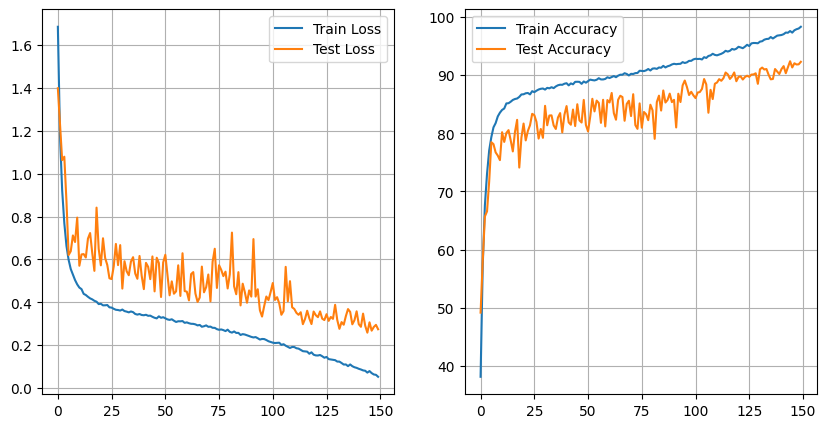

In [ ]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
x_axis = range(EPOCHS)
ax0.plot(x_axis, history['loss'], label='Train Loss')
ax0.plot(x_axis, history['test_loss'], label='Test Loss')
ax1.plot(x_axis, history['accuracy'], label='Train Accuracy')
ax1.plot(x_axis, history['test_accuracy'], label='Test Accuracy')
ax0.grid(True)
ax1.grid(True)
ax0.legend()
ax1.legend()
f.savefig("./trainTestCurve.png")

## Visualize the Predictions

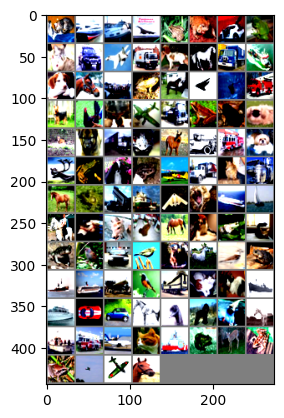

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## Plot Confusion Matrix

In [ ]:
def get_predictions(model, iterator, device):
  ## Set model to evaluate mode 

  model.eval()
  
  ## Labels and probability lists 

  labels = []
  probs = []
  
  with torch.no_grad():
    for (x,y) in iterator:
      x = x.to(device)
      y = y.to(device)
      y_pred = model(x)
      y_prob = F.softmax(y_pred, dim = -1)
      top_pred = y_prob.argmax(1, keepdim = True)
      labels.append(y.cpu())
      probs.append(y_prob.cpu())
  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)
  return labels, probs

In [ ]:
labels, probs = get_predictions(net, testloader, device)
pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
  fig = plt.figure(figsize = (10, 10));
  ax = fig.add_subplot(1, 1, 1);
  cm = confusion_matrix(labels, pred_labels);
  cm = ConfusionMatrixDisplay(cm, display_labels = classes);
  cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
  plt.xticks(rotation = 20)

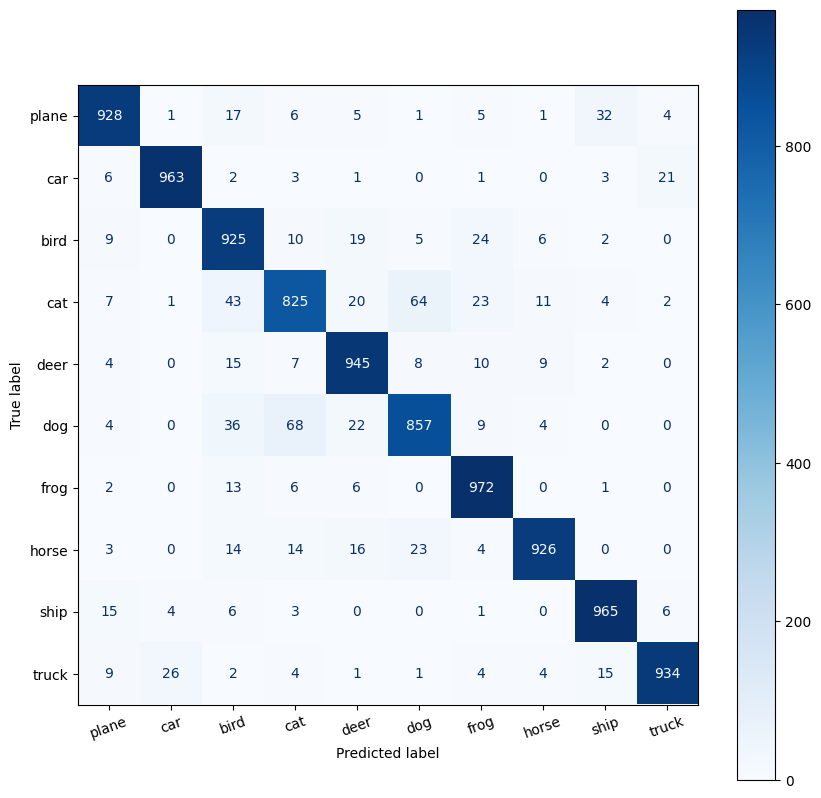

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)